In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from dataset_eval import Dataset
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np

from time import time
from visdom import Visdom
import copy

num_classes = 7
batch_size = 32
feature_extract = True
pretrained = True
input_size = 224

confusion_matrix = torch.zeros(num_classes, num_classes)

In [2]:
def confusion_matrix_plot(cm, classes, normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
def eval_model(model, dataloaders, test_ds):
    model.eval() 
    
    running_loss = 0.0
    running_corrects = 0
    
    # Iterate over data.
    for step, (inputs, labels) in enumerate(dataloaders):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        # loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels)
        
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

#     print(len(train_ds.image_list))
#     print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    
    confusion_matrix_plot(confusion_matrix.numpy(), test_ds.classes_name)
    
    return running_corrects/len(test_ds.image_list)

['sea', 'green', 'city', 'house_building', 'face', 'house_indoor', 'office']
tensor([0.9333, 0.9667, 0.8667, 1.0000, 1.0000, 0.5667, 0.9000])
Normalized confusion matrix
[[0.93333333 0.03333333 0.03333333 0.         0.         0.
  0.        ]
 [0.03333333 0.96666667 0.         0.         0.         0.
  0.        ]
 [0.06666667 0.06666667 0.86666667 0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.56666667
  0.43333333]
 [0.         0.         0.03333333 0.03333333 0.         0.03333333
  0.9       ]]
tensor(0.8905, device='cuda:0')


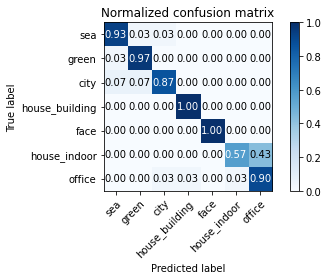

In [4]:
BASE_DIR = '/home/jun/Github/BoVW/dataset/'

test_ds = Dataset(BASE_DIR)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

model = models.resnet18(pretrained=pretrained).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)
# model =  torch.nn.DataParallel(model).cuda()
model.cuda()
model.load_state_dict(torch.load('./model/net26-0.004.pth'))

loss_fn = torch.nn.CrossEntropyLoss()
acc = eval_model(model, test_dl, test_ds)
print(acc)
